In [35]:
import torch
import torch.nn as nn
import numpy as np
import pickle, os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Original ConvLSTM cell as proposed by Shi et al.
class ConvLSTMCell(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size, padding, activation, frame_size
    ):

        super(ConvLSTMCell, self).__init__()

        if activation == "tanh":
            self.activation = torch.tanh
        elif activation == "relu":
            self.activation = torch.relu

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels,
            out_channels=4 * out_channels,
            kernel_size=kernel_size,
            padding=padding,
        )

        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev)
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev)

        # Current Cell output
        C = forget_gate * C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C)

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C


In [37]:
class ConvLSTM(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size, padding, activation, frame_size
    ):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(
            in_channels, out_channels, kernel_size, padding, activation, frame_size
        )

    def forward(self, X):

        # X is a frame sequence (batch_size, num_channels, seq_len, height, width)

        # Get the dimensions
        batch_size, _, seq_len, height, width = X.size()

        # Initialize output
        output = torch.zeros(
            batch_size, self.out_channels, seq_len, height, width, device=device
        )

        # Initialize Hidden State
        H = torch.rand(batch_size, self.out_channels, height, width, device=device)

        # Initialize Cell Input
        C = torch.rand(batch_size, self.out_channels, height, width, device=device)

        # Unroll over time steps
        for time_step in range(seq_len):

            H, C = self.convLSTMcell(X[:, :, time_step], H, C)

            output[:, :, time_step] = H

        return output


In [38]:
class Seq2Seq(nn.Module):
    def __init__(
        self,
        num_channels,
        num_kernels,
        kernel_size,
        padding,
        activation,
        frame_size,
        num_layers,
    ):

        super(Seq2Seq, self).__init__()

        self.sequential = nn.Sequential()

        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1",
            ConvLSTM(
                in_channels=num_channels,
                out_channels=num_kernels,
                kernel_size=kernel_size,
                padding=padding,
                activation=activation,
                frame_size=frame_size,
            ),
        )

        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        )

        # Add rest of the layers
        for l in range(2, num_layers + 1):

            self.sequential.add_module(
                f"convlstm{l}",
                ConvLSTM(
                    in_channels=num_kernels,
                    out_channels=num_kernels,
                    kernel_size=kernel_size,
                    padding=padding,
                    activation=activation,
                    frame_size=frame_size,
                ),
            )

            self.sequential.add_module(
                f"batchnorm{l}", nn.BatchNorm3d(num_features=num_kernels)
            )

        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels,
            out_channels=num_channels,
            kernel_size=kernel_size,
            padding=padding,
        )

    def forward(self, X):

        # Forward propagation through all the layers
        output = self.sequential(X)

        # Return only the last output frame
        output = self.conv(output[:, :, -1])

        return nn.Sigmoid()(output)


### Test `ConvLSTMCell` and `ConvLSTM` classes


In [39]:
in_channels = 1
out_channels = 10
kernel_size = 3
padding = "same"
activation = "relu"
frame_size = (5, 5)
batch_size = 3
seq_length = 10


In [40]:
lstm1 = ConvLSTMCell(
    in_channels, out_channels, kernel_size, padding, activation, frame_size
)
torch.manual_seed(0)
X = torch.rand(batch_size, in_channels, seq_length, *frame_size)
H = torch.rand(batch_size, out_channels, *frame_size)
C = torch.rand(batch_size, out_channels, *frame_size)
O1 = torch.zeros(batch_size, out_channels, seq_length, *frame_size)
for timestep in range(seq_length):
    H, C = lstm1(X[:, :, timestep], H, C)
    O1[:, :, timestep] = H


In [41]:
lstm2 = ConvLSTM(
    in_channels, out_channels, kernel_size, padding, activation, frame_size
)
torch.manual_seed(0)
X = torch.rand(batch_size, in_channels, seq_length, *frame_size)
O2 = lstm2(X)


In [42]:
# This should give the same answer.
print(O1[0, 0, 0, 0])
print(O2[0, 0, 0, 0])



tensor([0.1593, 0.0632,    nan, 0.0795, 0.0000], grad_fn=<SelectBackward0>)
tensor([0.3792, 0.0239, 0.1403, 0.1350, 0.2896], grad_fn=<SelectBackward0>)


### Test `Seq2Seq` class

In [43]:
num_channels = in_channels
num_kernels = out_channels
num_layers = 3

lstm3 = Seq2Seq(
    num_channels, num_kernels, kernel_size, padding, activation, frame_size, num_layers
)

X = torch.rand(batch_size, num_channels, seq_length, *frame_size)
O3 = lstm3(X)

print(X.size())
print(O3.size())


torch.Size([3, 1, 10, 5, 5])
torch.Size([3, 1, 5, 5])


In [44]:
in_channels = 1
out_channels = 10
kernel_size = (1, 3)
padding = "same"
activation = "relu"
frame_size = (1, 32)
batch_size = 3
seq_length = 10
num_channels = in_channels
num_kernels = out_channels
num_layers = 3


In [45]:
# Data folder
cwd = os.getcwd()
folderPFC = "T02 - PFC - ConvLSTM"
folderOutput = "2022-05-08-07-21-22"
rootFolder = os.path.dirname(cwd)  # Up one level
filePath = os.path.join(
    rootFolder, folderPFC, "output", folderOutput, "data_store.pickle"
)
print(filePath)


/home/nnnpooh/Coding/research/pfc-ml/T02 - PFC - ConvLSTM/output/2022-05-08-07-21-22/data_store.pickle


In [46]:
# Load data (deserialize)
with open(filePath, "rb") as handle:
    data_dict = pickle.load(handle)

data = data_dict["data"]
# nCol = data_dict["n"]
# nRow = 1
# nChannel = 1
# tFinal = data_dict["tf"]
# dx = data_dict["dx"]
# L = data_dict["L"]


In [47]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_length, num_channels, frame_size):
        X_, y_ = self.split_sequence(data, seq_length)
        X_ = X_.reshape(X_.shape[0], num_channels, seq_length, *frame_size)
        self.X = torch.tensor(X_)
        self.y = torch.tensor(y_)

    def __len__(self):
        "Denotes the total number of samples"
        return self.X.shape[0]

    def split_sequence(self, data, nSeq):
        X, y = list(), list()
        nRow = data.shape[0]
        for i in range(nRow):
            # find the end of this pattern
            end_ix = i + nSeq
            # check if we are beyond the sequence
            if end_ix > nRow - 1:
                break
                # gather input and output parts of the pattern
            seq_x, seq_y = data[i:end_ix, :], data[end_ix, :]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

    def __getitem__(self, index):
        "Generates one sample of data"
        # Select sample
        X = self.X[index]
        y = self.y[index]
        return X, y


In [48]:
ds = Dataset(data, seq_length, num_channels, frame_size)
train_loader = DataLoader(ds, shuffle=True, batch_size=2)
train_ = next(iter(train_loader))
print(train_[0].shape)
print(train_[1].shape)


torch.Size([2, 1, 10, 1, 32])
torch.Size([2, 32])


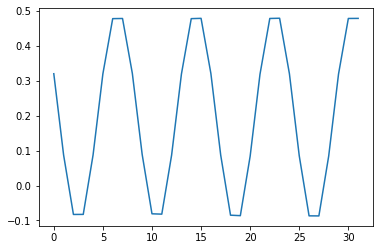

In [49]:
phi_ = train_[0][0,0,1,0,:].cpu().detach().numpy()
plt.plot(phi_)

In [51]:
lstm3 = Seq2Seq(
    num_channels, num_kernels, kernel_size, padding, activation, frame_size, num_layers
)


for count, (train_data, train_label) in enumerate(train_loader):
    lstm3(train_data)

RuntimeError: expected scalar type Double but found Float